In [1]:
import prody as pr
import numpy as np


nmr_model = pr.parsePDB('/home/joseph/Documents/FBB/1_Bioinformatics/prac5/6tpb.pdb')
RMSFs = [np.mean(pr.calcRMSF(res)) for res in nmr_model.iterResidues()]


xray_model = pr.parsePDB('/home/joseph/Documents/FBB/1_Bioinformatics/prac5/6nfr.pdb')
BETAs = list()
for res in xray_model.iterResidues():
    if ('HOH' in str(res) or 'SO4' in str(res)):
        continue
    BETAs.append(np.mean(res.getBetas()))
    
    
RMSFs = np.array(RMSFs)
BETAs = np.array(BETAs)

# print(len(RMSFs))
# print(len(BETAs))

@> 1426 atoms and 20 coordinate set(s) were parsed in 0.05s.
@> 955 atoms and 1 coordinate set(s) were parsed in 0.01s.


Pearson corr coeff = 0.6009393490943364; p-value = 7.6324532129041e-11


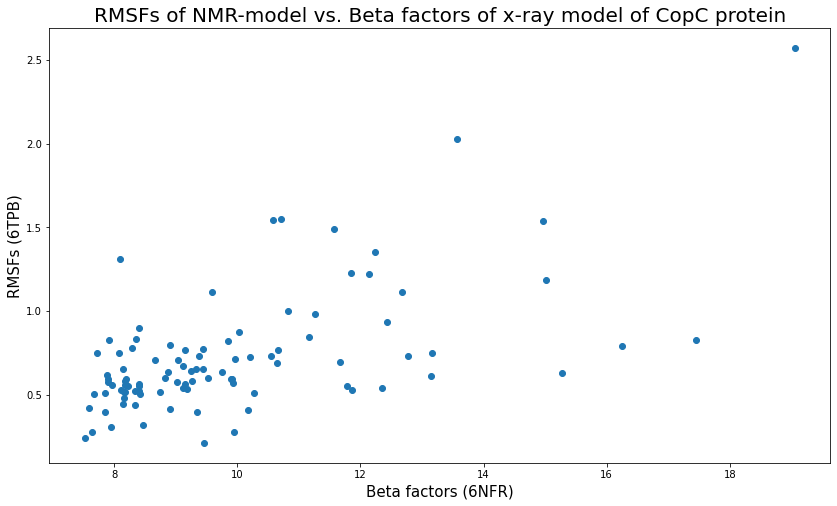

In [2]:
import scipy 

pearson_corcoef, pvalue = scipy.stats.pearsonr(BETAs, RMSFs)
print('Pearson corr coeff = ', pearson_corcoef, '; p-value = ', pvalue, sep = '')

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.scatter(BETAs, RMSFs)
plt.xlabel('Beta factors (6NFR)', fontsize=15)
plt.ylabel('RMSFs (6TPB)', fontsize=15)
plt.title('RMSFs of NMR-model vs. Beta factors of x-ray model of CopC protein', fontsize=20)


# putaway_outliers = BETAs < 12
# b = BETAs[putaway_outliers]
# r = RMSFs[putaway_outliers]


# a_1, a_0 = np.polyfit(b, r, 1)
# plt.scatter(b, a_1*b + a_0, color = "magenta", alpha=.3)

plt.savefig("/home/joseph/Documents/FBB/1_Bioinformatics/prac5/task2_rmsf_vs_beta.png",\
                         format = "png")


plt.show()

In [3]:
import pandas as pd

list_of_rows_atoms = list()

for res in nmr_model.iterResidues():
    resname = res.getResname()
    resnum = res.getResnum()
    atomlist = list()
    r_list = pr.calcRMSF(res)
    index = 0
    for atom in res.iterAtoms():
        atomname = str(atom).split()[1]
        if atomname[0] == 'H':
            index += 1
            continue
            
        atomlist.append(list([resname,resnum, atomname, int(atom.getIndex()), r_list[index]]))
        index += 1
    
    for resp in xray_model.iterResidues():
        if ((resname == str(resp.getResname())) and (resnum + 24 == int(resp.getResnum()))):
#             stop = str(input(resname + ' ' + str(resnum)))
            for atom in resp.iterAtoms():
                atomname = str(atom).split()[1]
                atomindex = int(atom.getIndex())
                atombeta = atom.getBeta()

                for index_, row in  enumerate(atomlist):

                    if row[2] == atomname:
                        atomlist[index_].append(atomindex)
                        atomlist[index_].append(atombeta)
#                     
            break

    list_of_rows_atoms.extend(atomlist)
      
table_atomic = pd.DataFrame()

for col_index in range(7):
    col = list()
    for row in list_of_rows_atoms:
        if len(row) < 7:
#             print(row)
            continue
        col.append(row[col_index])
    table_atomic[col_index] = col

In [4]:
table_atomic

0   1    2     3         4    5      6
0    HIS   1    N     0  2.003801    0  13.42
1    HIS   1   CA     1  1.374490    1  12.39
2    HIS   1    C     2  1.017325    2  11.65
3    HIS   1    O     3  1.065427    3  12.85
4    HIS   1   CB     4  1.405360    4  13.08
..   ...  ..  ...   ...       ...  ...    ...
684  VAL  95    C  1387  0.307637  695   8.45
685  VAL  95    O  1388  0.315383  696   9.04
686  VAL  95   CB  1389  0.283336  697   8.26
687  VAL  95  CG1  1390  0.356704  698   8.60
688  VAL  95  CG2  1391  0.277938  699   8.70

[689 rows x 7 columns]

Pearson corr coeff = 0.6689923556356518; p-value = 1.3631302320879874e-90


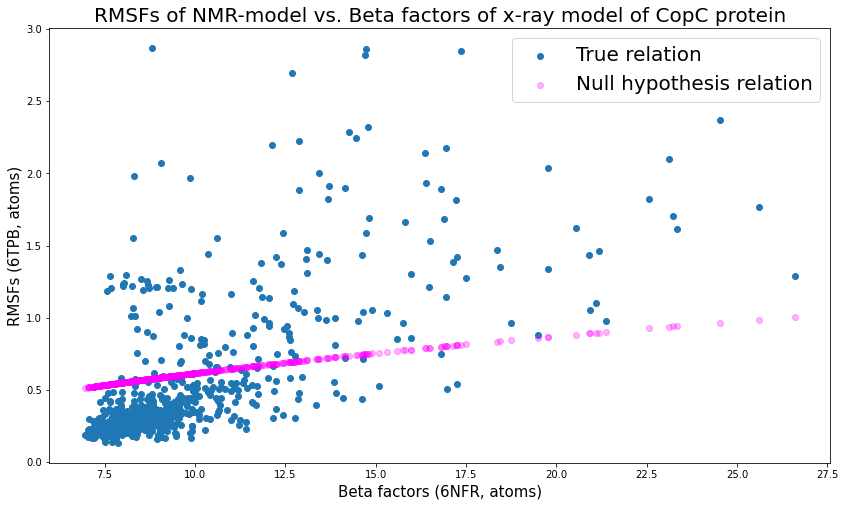

In [5]:
BETAs = table_atomic[6]
RMSFs = table_atomic[4]

pearson_corcoef, pvalue = scipy.stats.pearsonr(BETAs, RMSFs)
print('Pearson corr coeff = ', pearson_corcoef, '; p-value = ', pvalue, sep = '')

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.scatter(BETAs, RMSFs, label = 'True relation')
plt.xlabel('Beta factors (6NFR, atoms)', fontsize=15)
plt.ylabel('RMSFs (6TPB, atoms)', fontsize=15)
plt.title('RMSFs of NMR-model vs. Beta factors of x-ray model of CopC protein', fontsize=20)


myformula = lambda a : np.sqrt(((3 / 8) / (np.pi ** 2)) * (a))
plt.scatter(BETAs, myformula(BETAs), color = "magenta", alpha=.3, label = 'Null hypothesis relation')

plt.legend(fontsize=20)


plt.savefig("/home/joseph/Documents/FBB/1_Bioinformatics/prac5/task2_rmsf_vs_beta_atoms.png",\
                         format = "png")
plt.show()

# Task3

In [6]:
nmr_model = pr.parsePDB('/home/joseph/Documents/FBB/1_Bioinformatics/prac5/6tpb.pdb')
model_coords = list(nmr_model.getCoordsets())

for i in range(len(model_coords)):
    assert len(list(nmr_model.iterAtoms())) == len(model_coords[i])
assert len(model_coords) == 20 # т.е. у нас 20 моделей в nmr-структуре

nmr_residues = list(nmr_model.iterResidues())

@> 1426 atoms and 20 coordinate set(s) were parsed in 0.06s.


In [7]:
def GetDistanceAndAngleEachMode(donor, hydrogen, acceptor):
    mode_distances = pr.buildDistMatrix(donor.getCoordsets(), acceptor.getCoordsets()).diagonal()
    mode_angles = list()
    for mode_idx in range(len(donor.getCoordsets())):
        donor.setCoords(donor.getCoordsets()[mode_idx])
        hydrogen.setCoords(hydrogen.getCoordsets()[mode_idx])
        acceptor.setCoords(acceptor.getCoordsets()[mode_idx])
        mode_angles.append(pr.calcAngle(donor, hydrogen, acceptor))
    return np.array(mode_distances), np.array(mode_angles)

1. Предполагаемая водородная связь:
/6tpb/A/A/PHE`93/N (/6tpb/A/A/PHE`93/H), /6tpb/A/A/TYR`73/O

In [8]:
assert str(nmr_residues[92]) == 'PHE 93'

phe_n_atom = nmr_residues[92].getAtom('N')
phe_h_atom = nmr_residues[92].getAtom('H')

assert str(nmr_residues[72]) == 'TYR 73'
tyr_o_atom = nmr_residues[72].getAtom('O')

loc1_distances, loc1_angles = GetDistanceAndAngleEachMode(phe_n_atom, phe_h_atom, tyr_o_atom)

2. Предполагаемая водородная связь:
/6tpb/A/A/VAL`80/N (/6tpb/A/A/VAL`80/H), /6tpb/A/A/THR`34/OG1

In [9]:
assert str(nmr_residues[79]) == 'VAL 80'

val_n_atom = nmr_residues[79].getAtom('N')
val_h_atom = nmr_residues[79].getAtom('H')

assert str(nmr_residues[33]) == 'THR 34'
thr_o_atom = nmr_residues[33].getAtom('OG1')

loc2_distances, loc2_angles = GetDistanceAndAngleEachMode(val_n_atom, val_h_atom, thr_o_atom)

3. Предполагаемая водородная связь:
/6tpb/A/A/ASN`72/ND2 (/6tpb/A/A/ASN`72/HD22), /6tpb/A/A/ASP`41/OD1

In [10]:
assert str(nmr_residues[71]) == 'ASN 72'

asn_n_atom = nmr_residues[71].getAtom('ND2')
asn_h_atom = nmr_residues[71].getAtom('HD22')

assert str(nmr_residues[40]) == 'ASP 41'
asp_o_atom = nmr_residues[40].getAtom('OD1')

loc3_distances, loc3_angles = GetDistanceAndAngleEachMode(asn_n_atom, asn_h_atom, asp_o_atom)

2.9569940818337797 3.0644238743528867 3.148832958414911
3.69021530537176 4.0007740924198805 4.451913408861408
4.539373304763553 7.1662906593521996 10.22256274130905


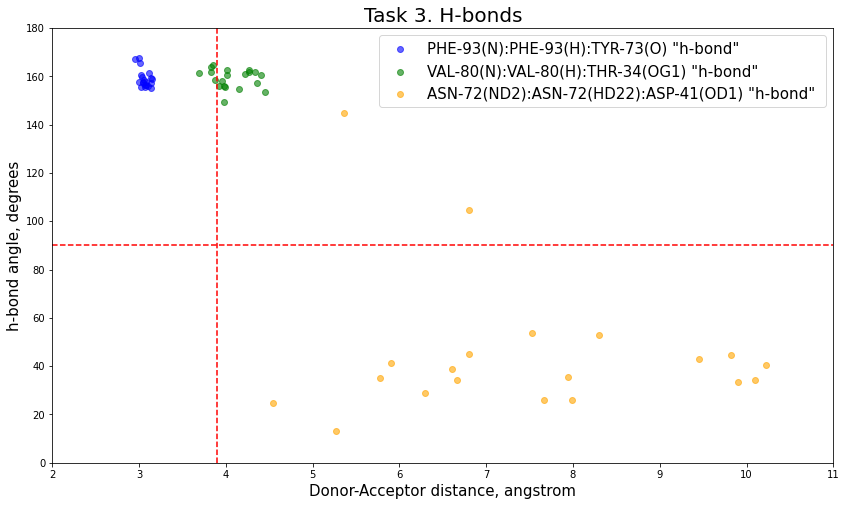

In [11]:
print(np.min(loc1_distances), np.median(loc1_distances), np.max(loc1_distances))
print(np.min(loc2_distances), np.median(loc2_distances), np.max(loc2_distances))
print(np.min(loc3_distances), np.median(loc3_distances), np.max(loc3_distances))

plt.figure(figsize=(14, 8))

plt.scatter(loc1_distances, loc1_angles, label='PHE-93(N):PHE-93(H):TYR-73(O) "h-bond" ', color='blue', alpha=.6)
plt.scatter(loc2_distances, loc2_angles, label='VAL-80(N):VAL-80(H):THR-34(OG1) "h-bond" ', color='green', alpha=.6)
plt.scatter(loc3_distances, loc3_angles, label='ASN-72(ND2):ASN-72(HD22):ASP-41(OD1) "h-bond" ', color='orange', alpha=.6)

plt.xlabel('Donor-Acceptor distance, angstrom', fontsize=15)
plt.ylabel('h-bond angle, degrees', fontsize=15)
plt.title('Task 3. H-bonds', fontsize=20)

plt.xlim(2,11)
plt.ylim(0, 180)

plt.axvline(x=3.9, color = 'red', linestyle='--')
plt.axhline(y=90, color = 'red', linestyle='--')

plt.legend(fontsize=15)

plt.savefig("/home/joseph/Documents/FBB/1_Bioinformatics/prac5/task3_hbonds.png",format = "png")

plt.show()